## Exercise

Load the national COVID dataset and solve the exercise using `scikit-learn` library.
Consider first the column corresponding to the (cumulative) number of deaths. 
1. Perform a train-test split, with observations from the last week corresponding to the test set;
2. Build a suitable combination of kernels choosing from the ones shown in `notebook_05`;
3. Fit a `GaussianProcessRegressor` to predict the daily number of swabs, plot future predictions and compare them to real test data;
4. Repeat points 1-3 on the daily number of swabs, which can be computed from the cumulative number provided in the dataset.

You are welcome to try out and fit other data streams in the dataset. 


In [74]:
import numpy as np
from sklearn import gaussian_process
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mt
import os
import pandas as pd
import datetime as dt

mt.rcParams['axes.titlesize'] = 20
mt.rcParams['axes.labelsize'] = 16
mt.rcParams['xtick.labelsize'] = 12
mt.rcParams['ytick.labelsize'] = 12
mt.rcParams['legend.fontsize'] = 14

In [86]:
# Load the monthly dataset
data_covid = pd.read_csv("data/COVID_national_20200421.csv")

# fix column names
cols = list(data_covid.columns[data_covid.columns != 'Unnamed: 0'])
data_covid = data_covid[cols]

# drop rows with nan
data_covid.dropna(inplace=True)

# set date as index
data_covid['date'] = pd.to_datetime(data_covid['date'])
data_covid = data_covid.set_index('date', drop=True)


data_covid.head()

,deaths,swabs,ICU,hospitalized,new_infections,cumulative_infections,recovered,quarantined
date,,,,,,,,
2020-02-24,7,4324,26,101,221,229,1,94
2020-02-25,10,8623,35,114,93,322,1,162
2020-02-26,12,9587,36,128,78,400,3,221
2020-02-27,17,12014,56,248,250,650,45,284
2020-02-28,21,15695,64,345,238,888,46,412


In [131]:
def dates_to_idx(timelist):
    reference_time = pd.to_datetime('1958-03-15')
    t = (timelist - reference_time) / pd.Timedelta(1, "Y")
    return np.asarray(t)

t = dates_to_idx(data_covid.index)

# log-scale
y = data_covid["swabs"].values
y_n = np.log10(y)

data_covid = data_covid.assign(t = t)
data_covid = data_covid.assign(y_n = y_n)

In [132]:
data_covid.head()

,deaths,swabs,ICU,hospitalized,new_infections,cumulative_infections,recovered,quarantined,t,y_n
date,,,,,,,,,,
2020-02-24,7,4324,26,101,221,229,1,94,61.947884,3.635886
2020-02-25,10,8623,35,114,93,322,1,162,61.950622,3.935658
2020-02-26,12,9587,36,128,78,400,3,221,61.953360,3.981683
2020-02-27,17,12014,56,248,250,650,45,284,61.956098,4.079688
2020-02-28,21,15695,64,345,238,888,46,412,61.958836,4.195761


In [133]:
# split into training and test set
sep_idx = data_covid.index.searchsorted(pd.to_datetime("2020-04-13"))
data_early = data_covid.iloc[:sep_idx+1, :]
data_later = data_covid.iloc[sep_idx:, :]

Text(0.5,1,'Swabs as a function of time index')

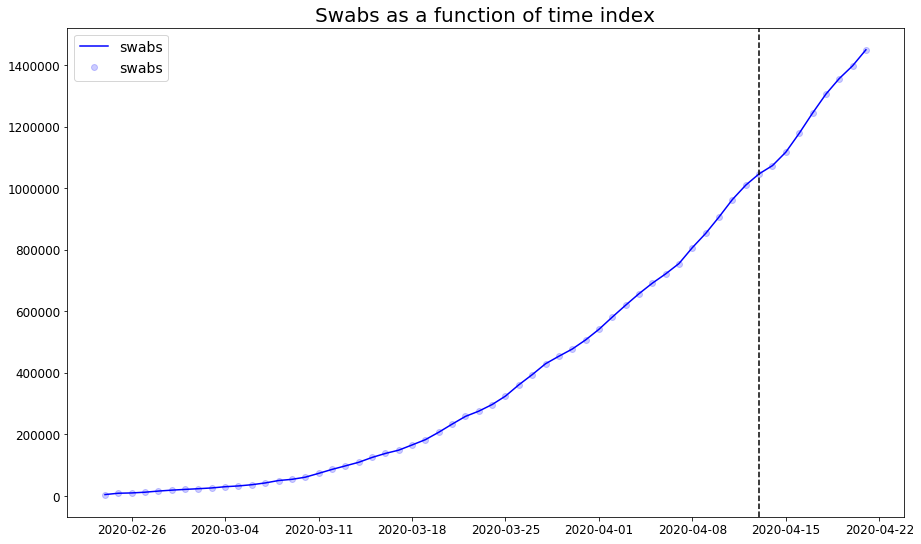

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
ax.plot(data_covid.index.values, data_covid.swabs, color='b')
ax.plot(data_covid.index.values, data_covid.swabs, color='b', marker='o', linestyle='', alpha=0.2)
ax.axvline("2020-04-13", linestyle='--', color='k')
ax.legend()
ax.set_title('Swabs as a function of time index')

Text(0.5,1,'Swabs as a function of time index')

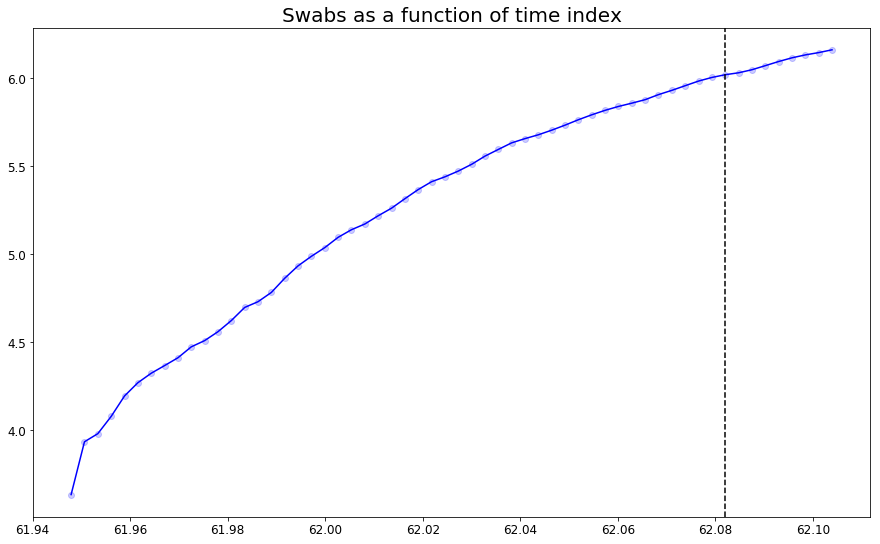

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
ax.plot(data_covid.t.values, data_covid.y_n.values, color='b')
ax.plot(data_covid.t.values, data_covid.y_n.values, color='b', marker='o', linestyle='', alpha=0.2)
ax.axvline(dates_to_idx(pd.to_datetime("2020-04-13")), linestyle='--', color='k')
#ax.legend()
ax.set_title('Swabs as a function of time index')

In [136]:
from sklearn.gaussian_process.kernels import DotProduct, RBF, ExpSineSquared, RationalQuadratic, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

In [166]:
X = data_covid.t.values[:, None]
y = data_covid.y_n.values
train_X = X[:len(data_early)]
train_y = y[:len(data_early)]
test_X = X[len(data_early):]
test_y = y[len(data_early):]

In [185]:
def plot_predictions(gp, include_observed=True):
    pred_y, pred_std = gp.predict(X, return_std=True)
    plt.figure(figsize=(10, 7))
    x = X[:, 0]
    if include_observed:
        plt.plot(x, y, 'ok', alpha=0.1)
    l, = plt.plot(x, pred_y)
    plt.fill_between(x,
                     pred_y + pred_std,
                     pred_y - pred_std,
                     color=l.get_color(), alpha=0.3)
    if np.allclose(X[:, 0], data_covid.t.values):
        plt.axvline(dates_to_idx(pd.to_datetime("2020-04-13")), linestyle='--', color='k')
    else:
        plt.axvline(pd.to_datetime("2020-04-13"), linestyle='--', color='k')

In [177]:
dot = ExpSineSquared()

k1 = dot # Long term trend

# Create the regressor
gp0 = GaussianProcessRegressor(kernel=k1, alpha=0.01,
                               normalize_y=True,
                               n_restarts_optimizer=3)
gp0

GaussianProcessRegressor(alpha=0.01, copy_X_train=True,
             kernel=ExpSineSquared(length_scale=1, periodicity=1),
             n_restarts_optimizer=3, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [178]:
# Train the regressor
gp0.fit(train_X, train_y)

GaussianProcessRegressor(alpha=0.01, copy_X_train=True,
             kernel=ExpSineSquared(length_scale=1, periodicity=1),
             n_restarts_optimizer=3, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [179]:
gp0.kernel

ExpSineSquared(length_scale=1, periodicity=1)

In [180]:
# We can see the kernel after training in the kernel_ attribute
gp0.kernel_

ExpSineSquared(length_scale=0.00204, periodicity=275)

In [181]:
# All other parameters of the GP
gp0.get_params()

{'alpha': 0.01,
 'copy_X_train': True,
 'kernel__length_scale': 1.0,
 'kernel__periodicity': 1.0,
 'kernel__length_scale_bounds': (1e-05, 100000.0),
 'kernel__periodicity_bounds': (1e-05, 100000.0),
 'kernel': ExpSineSquared(length_scale=1, periodicity=1),
 'n_restarts_optimizer': 3,
 'normalize_y': True,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

In [182]:
# The log marginal likelihood of the MAP can be found after training
gp0.log_marginal_likelihood_value_

51.55126606253548

In [183]:
# The fitted kernel's parameters are packed into an array
gp0.kernel_.theta

array([-6.19355289,  5.61511364])

Text(0.5,1,'ExpSineSquared(length_scale=0.00204, periodicity=275)')

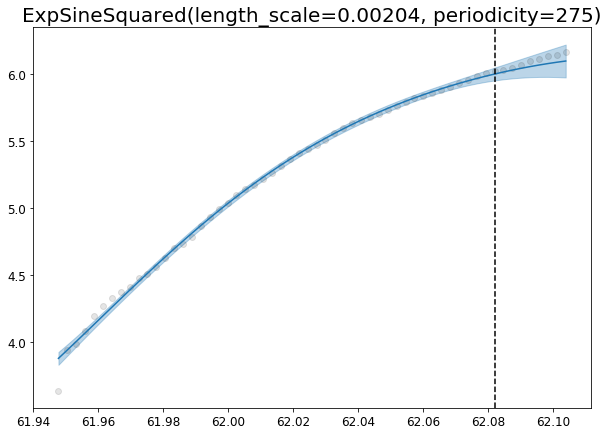

In [186]:
plot_predictions(gp0)
plt.title(str(gp0.kernel_))

Text(0.5,1,'Swabs as a function of time index')

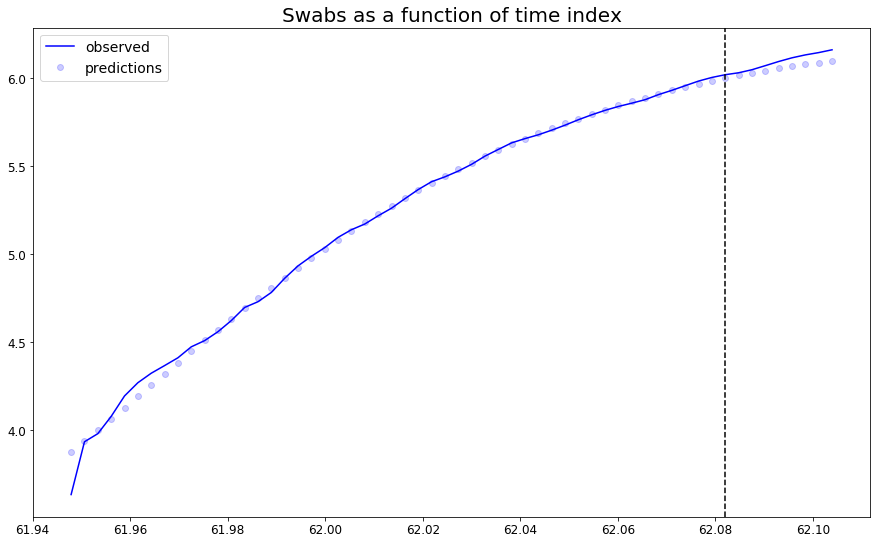

In [202]:
Y_hat = (gp0.predict(X))

data_covid = data_covid.assign(y_hat = Y_hat)


fig, ax = plt.subplots(1, 1, figsize=(15, 9))
ax.plot(data_covid.t.values, data_covid.y_n.values, color='b', label='observed')
ax.plot(data_covid.t.values, Y_hat, color='b', marker='o', linestyle='', alpha=0.2, label="predictions")
ax.axvline(dates_to_idx(pd.to_datetime("2020-04-13")), linestyle='--', color='k')
ax.legend()
ax.set_title('Swabs as a function of time index')